In [43]:
library(astsa)

# read data to R variable
birth.data<-read.csv("daily_birth.csv")

# pull out number of births column
number_of_births<-birth.data$Daily.total.female.births.in.California..1959

# use date format for dates
birth.data$Date <- as.Date(birth.data$Date, "%m/%d/%Y")

number_of_births=ts(number_of_births)

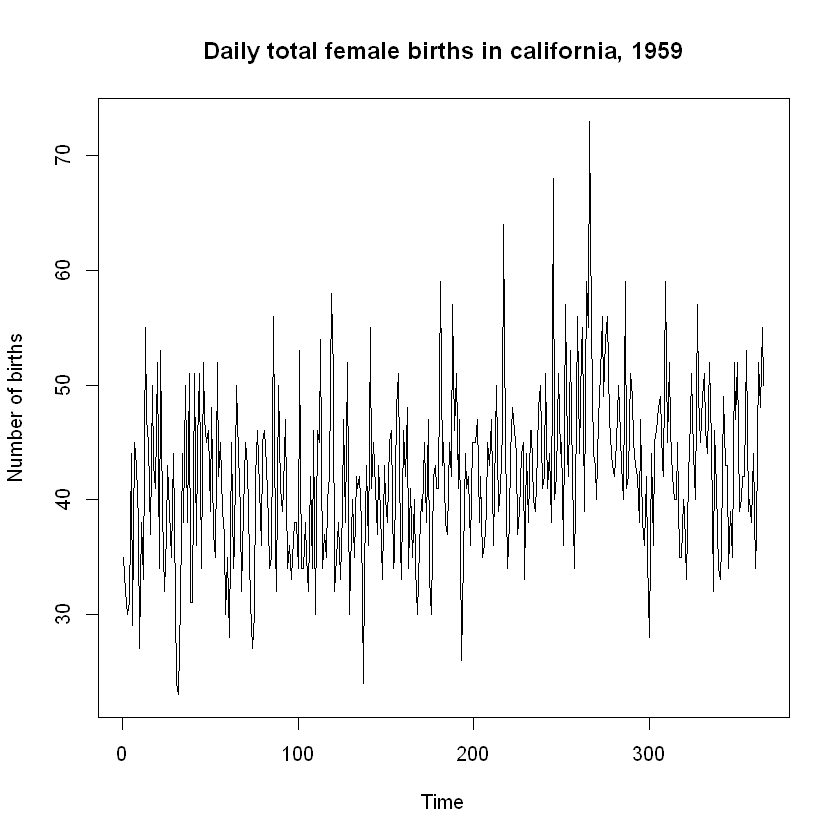

In [2]:
plot(number_of_births,main='Daily total female births in california, 1959', ylab = 'Number of births')

Clearly the time series has some trend and hence not stationary.

In [3]:
# Test for correlation
Box.test(number_of_births, lag = log(length(number_of_births)))


	Box-Pierce test

data:  number_of_births
X-squared = 36.391, df = 5.8999, p-value = 2.088e-06


p value is really small so we reject the NULL Hypothesis that there wont be any autocorrelation for all lag.

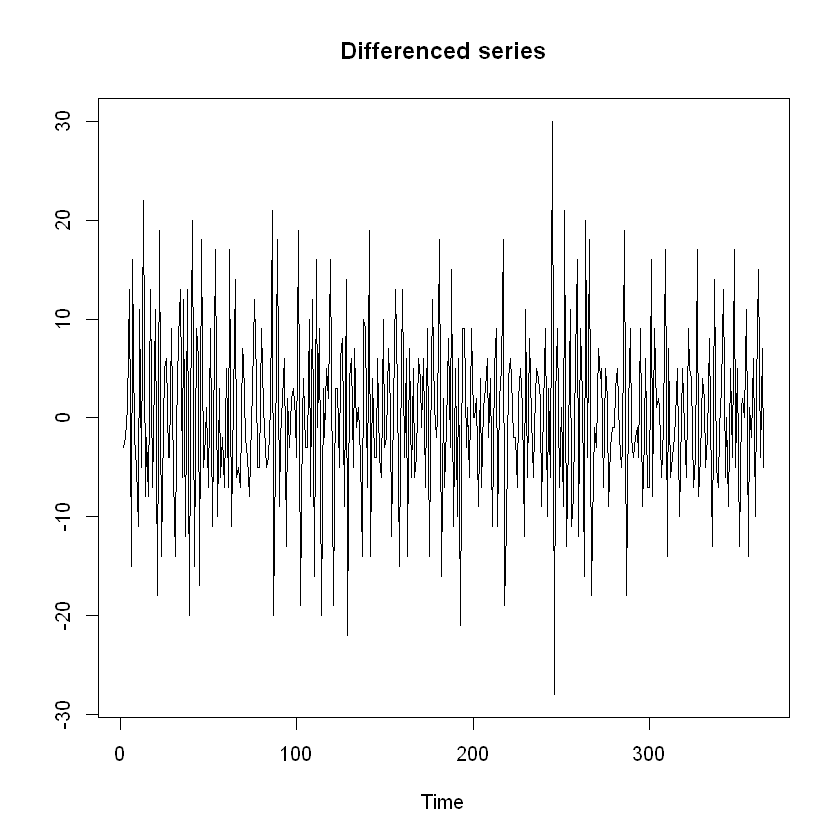

In [4]:
# Plot the differenced data
plot(diff(number_of_births), main='Differenced series', ylab = '')

first Difference looks like stationary.

In [5]:
# Test for correlation in the differenced data
Box.test(diff(number_of_births), lag = log(length(diff(number_of_births))))


	Box-Pierce test

data:  diff(number_of_births)
X-squared = 78.094, df = 5.8972, p-value = 7.661e-15


Again p value is really small for first difference.

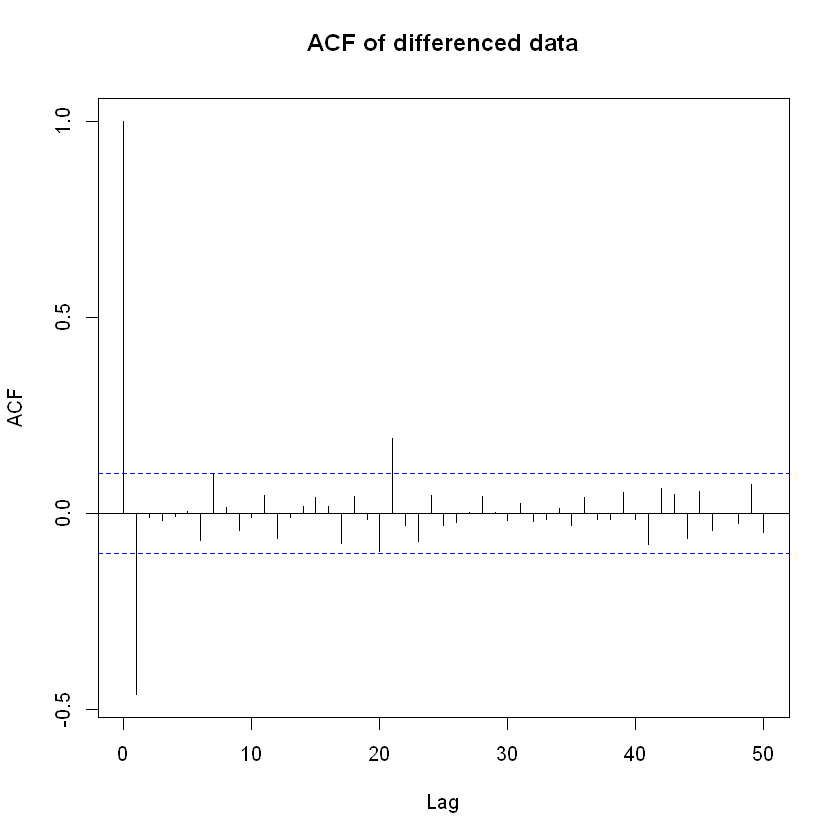

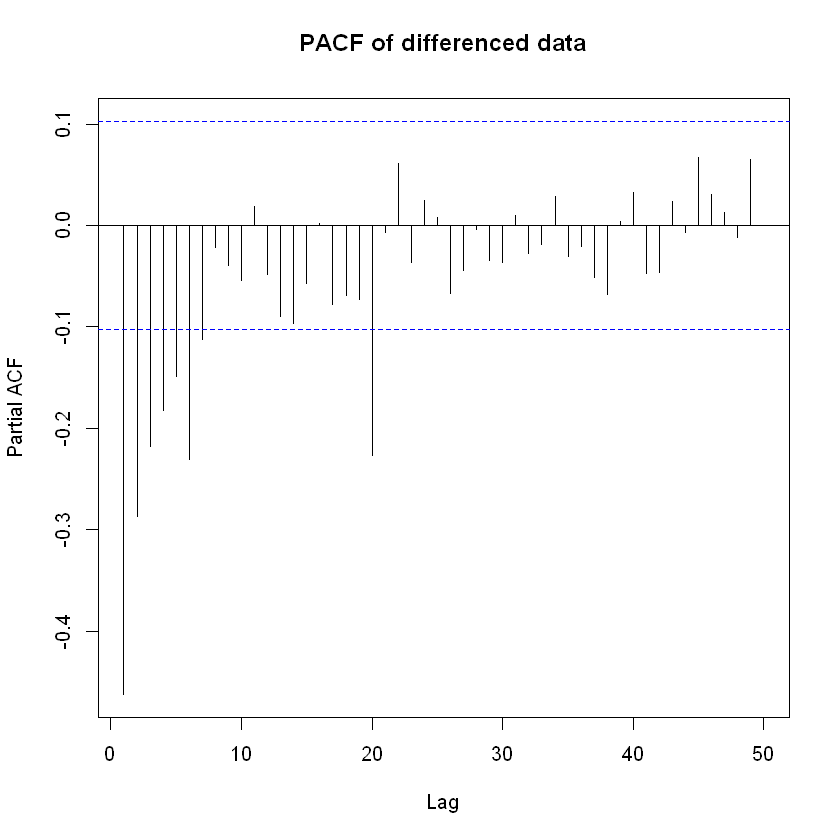

In [6]:
# acf and pacf of the differenced data
acf(diff(number_of_births), main='ACF of differenced data', 50)
pacf(diff(number_of_births), main='PACF of differenced data', 50)

From ACF we get hint at MA(1) process and AR(7) from PACF.

### Fit various ARIMA models


In [7]:
model1<-arima(number_of_births, order=c(0,1,1))
SSE1<-sum(model1$residuals^2)
model1.test<-Box.test(model1$residuals, lag = log(length(model1$residuals)))

In [8]:
model2<-arima(number_of_births, order=c(0,1,2))
SSE2<-sum(model2$residuals^2)
model2.test<-Box.test(model2$residuals, lag = log(length(model2$residuals)))

In [9]:
model3<-arima(number_of_births, order=c(7,1,1))
SSE3<-sum(model3$residuals^2)
model3.test<-Box.test(model3$residuals, lag = log(length(model3$residuals)))

In [10]:
model4<-arima(number_of_births, order=c(7,1,2))
SSE4<-sum(model4$residuals^2)
model4.test<-Box.test(model4$residuals, lag = log(length(model4$residuals)))

In [11]:
df<-data.frame(row.names=c('AIC', 'SSE', 'p-value'), 
               c(model1$aic, SSE1, model1.test$p.value), 
               c(model2$aic, SSE2, model2.test$p.value), 
               c(model3$aic, SSE3, model3.test$p.value),
               c(model4$aic, SSE4, model4.test$p.value))

colnames(df)<-c('Arima(0,1,1)','Arima(0,1,2)', 'Arima(7,1,1)', 'Arima(7,1,2)')
format(df, scientific=FALSE)

,"Arima(0,1,1)","Arima(0,1,2)","Arima(7,1,1)","Arima(7,1,2)"
AIC,2462.2207021,2459.5705306,2464.8827225,2466.6664136
SSE,18148.4561632,17914.6513437,17584.3902548,17574.0578118
p-value,0.5333604,0.9859227,0.9999899,0.9999929


initial  value 2.216721 
iter   2 value 2.047518
iter   3 value 1.974780
iter   4 value 1.966955
iter   5 value 1.958906
iter   6 value 1.952299
iter   7 value 1.951439
iter   8 value 1.950801
iter   9 value 1.950797
iter  10 value 1.950650
iter  11 value 1.950646
iter  12 value 1.950638
iter  13 value 1.950635
iter  13 value 1.950635
iter  13 value 1.950635
final  value 1.950635 
converged
initial  value 1.950708 
iter   2 value 1.950564
iter   3 value 1.950290
iter   4 value 1.950196
iter   5 value 1.950185
iter   6 value 1.950185
iter   7 value 1.950185
iter   7 value 1.950185
iter   7 value 1.950185
final  value 1.950185 
converged


$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = constant, transform.pars = trans, fixed = fixed, 
    optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
          ma1      ma2  constant
      -0.8511  -0.1113     0.015
s.e.   0.0496   0.0502     0.015

sigma^2 estimated as 49.08:  log likelihood = -1226.36,  aic = 2460.72

$degrees_of_freedom
[1] 361

$ttable
         Estimate     SE  t.value p.value
ma1       -0.8511 0.0496 -17.1448  0.0000
ma2       -0.1113 0.0502  -2.2164  0.0273
constant   0.0150 0.0150   1.0007  0.3176

$AIC
[1] 6.760225

$AICc
[1] 6.760408

$BIC
[1] 6.803051


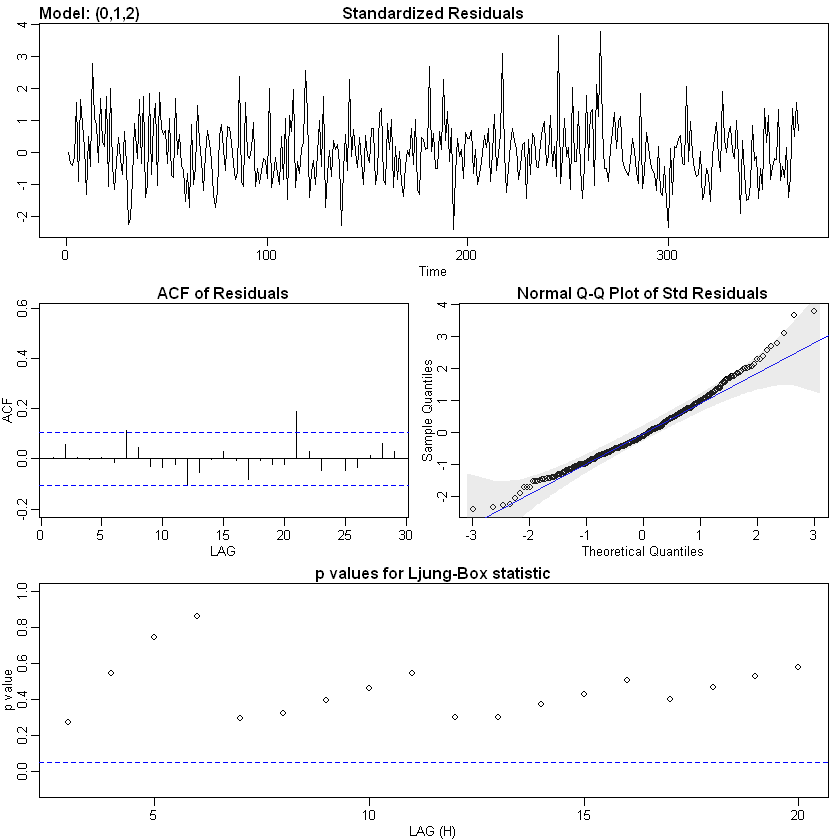

In [12]:
# Fit a SARIMA model
sarima(number_of_births, 0,1,2,0,0,0)

## Overlapping the simulated on real ts

The modeled time series:

<h2><center>𝑋<sub>𝑡</sub> = 𝑋<sub>𝑡−1</sub> + 0.015+𝑍<sub>𝑡</sub> − 0.8511𝑍<sub>𝑡−1</sub> − 0.1113𝑍<sub>𝑡−2</sub> <br>
    where <br>
    <center> 𝑍<sub>𝑡</sub> ~ 𝑁𝑜𝑟𝑚𝑎𝑙(0,49.08)</h2>

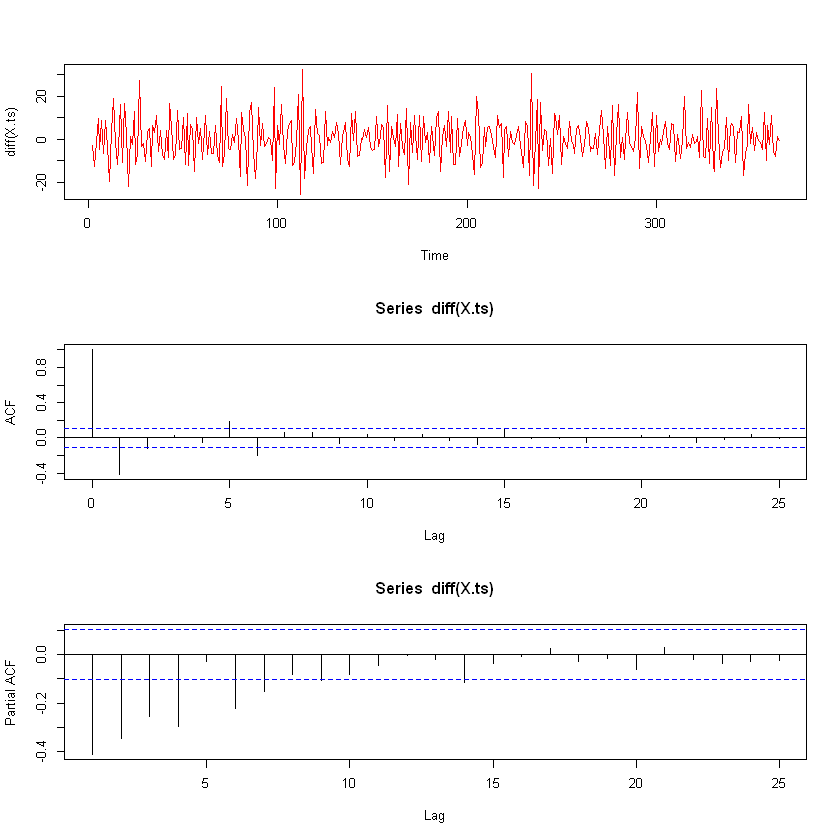

In [34]:
X=NULL
N=365
Z=rnorm(N,0,sqrt(49.08))
X[1]=35
X[2]=32

for (t in 3:N) {
X[t] = X[t-1] + 0.015 + Z[t] - 0.8511*Z[t-1] - 0.1113*Z[t-2] ;
}
X.ts = ts(X)

par(mfrow=c(3,1))
plot(diff(X.ts), col='red')
acf(diff(X.ts))
pacf(diff(X.ts))

Note the ACF and PACF are identical to the original time series above.

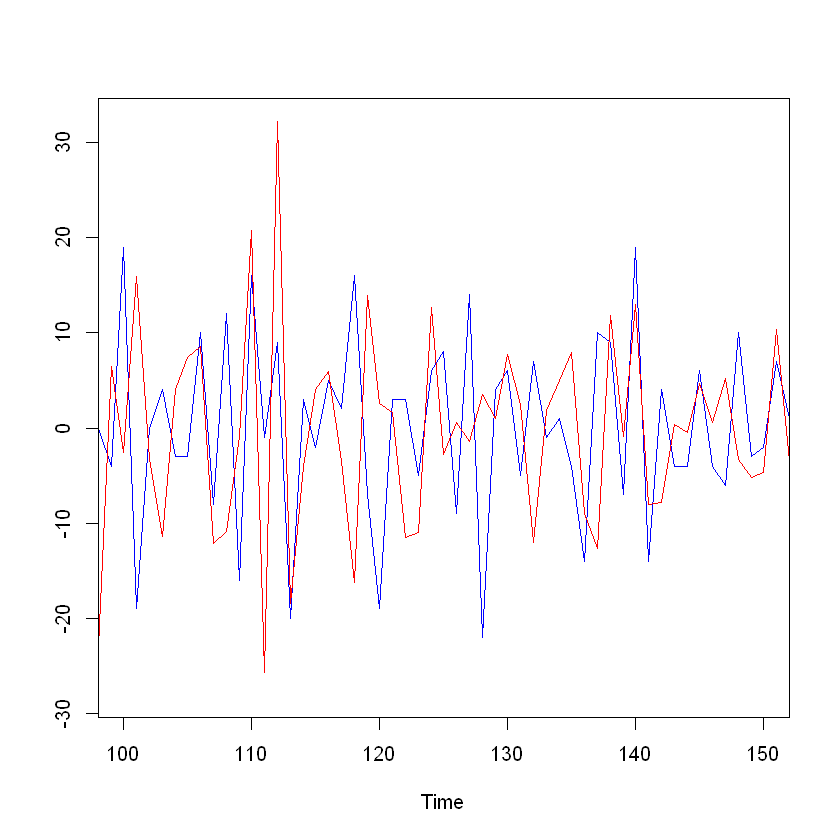

In [42]:
x = diff(number_of_births)
y = diff(X.ts)
ts.plot(ts(x), ts(y), gpars = list(col = c("blue", "red")), xlim=c(100,150))

Red is predicted/modelled Xt. Blue is original time series from data.